In [2]:
import numpy as np
import nengo
import nengo_spa as spa
import matplotlib.pyplot as plt
from nengo_spa.examine import pairs
from nengo_spa.exceptions import SpaParseError, SpaTypeError

rng = np.random.RandomState(0) # random number generator


# Vector transformation binding

You can bind $\mathbf{x},\mathbf{y}\in\mathbb{R}^{d^{2}}$ by [vector transformation binding](http://compneuro.uwaterloo.ca/files/publications/gosmann.2019b.pdf).

Since $\mathbf{y}$ has length $d^{2}$, it can be squished into a $d\times d$ square matrix. Now fill the diagonal of a $d^{2}\times d^{2}$ square with $d$ of these squished squares to form $V_{y}$.

The binding $\mathcal{B}(\mathbf{x},\mathbf{y})$ is defined
$$
\mathcal{B}(\mathbf{x},\mathbf{y})=\sqrt{ d }\cdot V_{y}\mathbf{x}.
$$
To get back $\mathbf{x}$ from $\mathcal{B}(\mathbf{x},\mathbf{y})$, the unbinding $\mathcal{B}(\mathbf{z},\mathbf{y})$ is defined
$$
\mathcal{B}^{+}(\mathbf{z},\mathbf{y})=\frac{1}{\sqrt{ d }}\cdot V_{y}^{T}\mathbf{z}.
$$
Perfect recovery of $\mathbf{x}$ occurs when $V_{y}$ is unitary, which is quite unlikely because $\mathbf{x},\mathbf{y}$ are sampled from normalized uniform distribution.
But if you squint a little, this binding operation is doing **"batched" circular convolution**, and even performs slightly better.

I am a bit suspicious of the scaling factor $\sqrt{ d }$. Increasing magnitude after binding is needed to prevent vectors from vanishing scaling takes less ensembles than normalizing. However, in the original `nengo_spa.algebras.VtbAlgebra()`, both bindng and unbinding scale by $\sqrt{ d }$. Since $V_{y}^TV_{y}$ is approximately unitary [\[1\]](http://compneuro.uwaterloo.ca/files/publications/gosmann.2019b.pdf), unbinding should scale by $\frac{1}{\sqrt{ d }}$.

Anyhow I'll normalize while computing similarity.

## Algorithm
No `nengo` yet just `numpy`.
There might be unexpected behaviour boosts coming from neural simulation.

In [8]:
'''Compute B(x,y) in Vector-Derived Transformation Binding.
@param dp Natural number.
@param x Normalized vector of size (dp**2, )
@param y Normalized vector of size (dp**2, )
'''
def bind(dp,x,y):
    Vyp = np.reshape(y,(dp,dp))
    fill = np.zeros((dp,dp))

    brows = []
    for bj in range(dp):
        brow = dp * [fill]
        brow[bj] = Vyp
        brows.append(brow)

    Vy = np.block(brows)
    # print(f'Vy {Vy}')
    # print(f'Vy.shape {Vy.shape}')

    return np.sqrt(d) * Vy @ x

'''Compute B+(x, y) in Vector-Derived Transformation Binding.
@param dp Natural number.
@param x Normalized vector of size (dp**2, )
@param y Normalized vector of size (dp**2, )
'''
def unbind(dp,x,y):
    Vyp = np.reshape(y,(dp,dp))
    fill = np.zeros((dp,dp))

    brows = []
    for bj in range(dp):
        brow = dp * [fill]
        brow[bj] = Vyp
        brows.append(brow)

    Vy = np.block(brows)
    # print(f'Vy {Vy}')
    # print(f'Vy.shape {Vy.shape}')

    return np.sqrt(d) * Vy.T @ x


## Unbinding test
After binding with yourself or something else, you should be able to unbind into yourself.

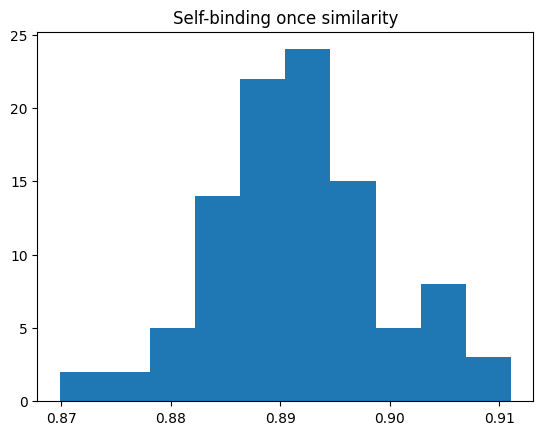

Similarity after binding and unbinding once with self: 0.89 ± 5.94e-05


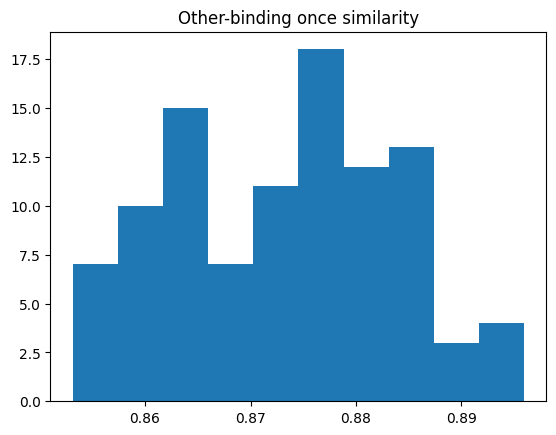

Similarity after binding and unbinding once with other: 0.87 ± 1.09e-04
Similarity of 2 vectors from Unif distribution: 0.75 ± 3.91e-04Nengo will discard anything with > 0.5 similarity. This is a bit concerning because no random pair had < 0.5 similarity in 100 tries.


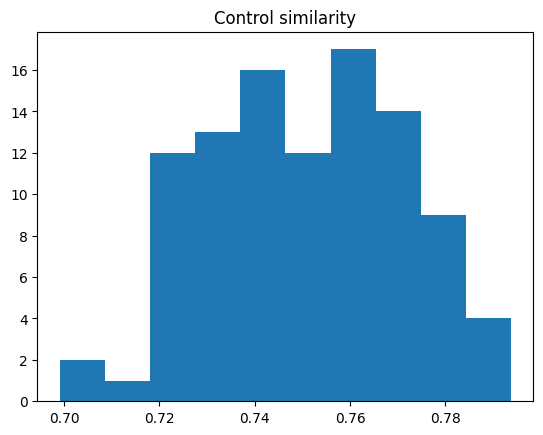

In [17]:
test = 100
d = 16

# self-binding
similarities = np.zeros(test)
for i in range(test):
    x = np.random.rand(d**2)
    x = x / np.linalg.norm(x)
    xp = unbind(d,bind(d,x,x),x)
    # normalize during the step where you dot
    xp = xp / np.linalg.norm(xp)  # |xp| is either ~10 or ~0.7, depending whether unbind scales by sqrt(d) or 1/sqrt(d)
    similarities[i] = x @ xp

plt.hist(similarities)
plt.title('Self-binding once similarity')
plt.show()

print(f'Similarity after binding and unbinding once with self: '
      f'{np.mean(similarities):.2f} ± {np.var(similarities):.2e}')

# other binding
similarities = np.zeros(test)
for i in range(test):
    x, y = np.random.rand(d**2), np.random.rand(d**2)
    x, y = x / np.linalg.norm(x), y / np.linalg.norm(y)
    xp = unbind(d,bind(d,x,y),y)
    # normalize during the step where you dot
    xp = xp / np.linalg.norm(xp)  # |xp| is either ~10 or ~0.7, depending whether unbind scales by sqrt(d) or 1/sqrt(d)
    similarities[i] = x @ xp

plt.hist(similarities)
plt.title('Other-binding once similarity')
plt.show()

print(f'Similarity after binding and unbinding once with other: '
      f'{np.mean(similarities):.2f} ± {np.var(similarities):.2e}')

# control: similarity of two Unif normalized vectors
similarities = np.zeros(test)
for i in range(test):
    x, y = np.random.rand(d**2), np.random.rand(d**2)
    x, y = x / np.linalg.norm(x), y / np.linalg.norm(y)
    similarities[i] = x @ y

print(f'Similarity of 2 vectors from Unif distribution: '
      f'{np.mean(similarities):.2f} ± {np.var(similarities):.2e}'
      f'Nengo will discard anything with > 0.5 similarity. This is a bit concerning because no random pair had < 0.5 similarity in 100 tries.')

plt.hist(similarities)
plt.title('Control similarity')
plt.show()

#### Results
Binding and unbinding with another vector yields 0.87 similarity with original. When trying to determine what the unbound thing is in clean-up memory, the answer is clear if all semantic pointers in the vocabulary have similarity < 0.5.

# Neural simulation
am a bit suspicious of `vtb.bind()` always multiplying by $\sqrt{ d }$ for binding in $\mathbb{R}^{d^{2}}$, even when creating `spa.Bind(vocab,unBind_left=True)`.

In [56]:
d = 4
# specify dimensionality of vocabulary and choose VTB algebra
vocab = spa.Vocabulary(d**2,
                    algebra=spa.algebras.VtbAlgebra(),
                    pointer_gen=rng)
test = 10  # 100 tests will crash!
similarities = np.zeros(test)

In [ ]:
# other-binding test
for i in range(test):
    x, y = np.random.rand(d**2), np.random.rand(d**2)
    x, y = x / np.linalg.norm(x), y / np.linalg.norm(y)

    with spa.Network(seed=0) as model:
        state_a = spa.State(vocab)
        state_b = spa.State(vocab)
        bind = spa.Bind(vocab)
        unbind = spa.Bind(vocab,unbind_left=True)
        a_input = spa.Transcode(lambda t : np.array(x), output_vocab=vocab)
        b_input = spa.Transcode(lambda t : np.array(y), output_vocab=vocab)

        # connect input to ensemble
        a_input >> state_a
        b_input >> state_b
        # feed to binding ensemble
        state_a >> bind.input_left
        state_b >> bind.input_right
        # unbind to get back x
        bind >> unbind.input_left
        state_b >> unbind.input_right

        b = nengo.Probe(bind.output, synapse=0.03)
        p = nengo.Probe(unbind.output, synapse=0.03)

    with nengo.Simulator(model) as sim:
        sim.run(1)

    # take unbind result to be the average 16D vector over the second 0.5s
    xp = np.mean(sim.data[p][500:],axis=0)
    xp = xp / np.linalg.norm(xp)  # xp had grown larger
    similarities[i] = xp @ x
    print(xp / np.linalg.norm(xp) @ x)

    bxy = np.mean(sim.data[b][500:],axis=0)
    print(np.linalg.norm(bxy))



Local server bravely computed 100 tests, holding 100 binding networks in memory:

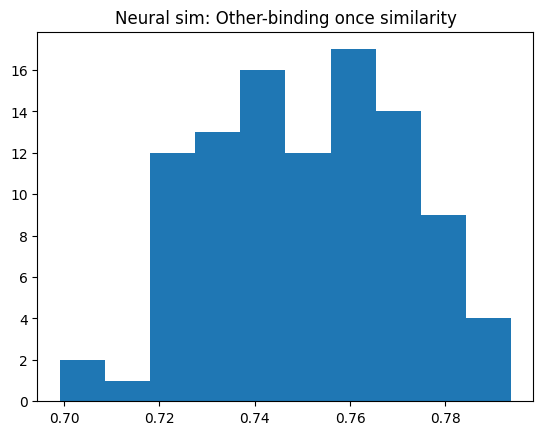

Similarity after binding and unbinding once with other semantic pointer in neural simulation:
d^2 = 16
0.75 ± 3.91e-04


In [23]:
plt.hist(similarities)
plt.title('Neural sim: Other-binding once similarity')
plt.show()

print(f'Similarity after binding and unbinding once with other semantic pointer in neural simulation:\n'
      f'd^2 = 16\n'
      f'{np.mean(similarities):.2f} ± {np.var(similarities):.2e}')

# Conclusion

Neural simulation is a bit sloppier just numbers, at 0.75 vs 0.87, but both are still very good if competing against < 0.5 in clean-up memory.

However, it is likely that binding two vectors of similarity < 0.5 has not been done yet. Need vocabulary generator.